# Deep Learning Course - Spring 2025 - Sharif University of Technology
## Homework 4 - DDPM (60 points + 34 extra points)

*Instructor:  Dr. Soleymani*

---

*Full Name:* Reza Ghorbani Paji

*SID:* 403206565

---

This homework helps you implement a Denoising Diffusion Probabilistic Model (DDPM) and Classifier-free diffusion guidance.  
As the main part, you can use the [DDPM paper](https://arxiv.org/pdf/2006.11239.pdf) and [classifier-free guidance](https://arxiv.org/abs/2207.12598) as references.

In this homework you need to complete the notebook and run all the cells.
We have specified the parts to be completed with `TODO` tags inside the code blocks.

**NOTES**:
* It is important that you read all the code and text blocks carefully, even if you think you are excited to jump into completing the missing codes.
* This notebook is tested with *Google Colab* and *Kaggle* free runtimes and you can used them for testing your code.
* Ensure all cells are executable and perform their intended functions
* You can ask your questions on [Quera Class](https://quera.org/course/20754)
* Write clear, commented code when necessary.

# Introduction

Denoising Diffusion Probabilistic Models (DDPMs) are deep generative models that have recently gained significant attention due to their remarkable performance. Cutting-edge models such as OpenAI’s DALL-E 2 and Google’s Imagen generators are built upon DDPMs.

The core concept is straightforward: given an image dataset, we progressively add small amounts of noise in multiple steps. With each step, the image becomes increasingly unclear until it turns into pure noise—this is known as the "forward process." Then, we train a machine learning model to reverse these steps, a process referred to as the "backward process." If the backward process is successfully learned, the model can generate images from random noise.

In the forward process, each step involves adding noise to an image (denoted as $x_t$) by sampling from a multivariate Gaussian distribution. The mean of this distribution is a scaled-down version of the previous image ($x_{t-1}$), while the covariance matrix remains diagonal and fixed. Essentially, each pixel in the image is independently perturbed by adding a normally distributed value.

![image](https://learnopencv.com/wp-content/uploads/2023/01/diffusion-models-forwardbackward_process_ddpm.png)

For the backward process, the model is expected to follow a Gaussian distribution, meaning it must predict the mean and standard deviation of the distribution given the noisy image and time step. In the original DDPM paper, the covariance matrix is fixed, so the primary objective is to predict the mean of the Gaussian distribution based on the noisy image and the current time step.

![image](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-overall_forward_diffusion_process-1.png)

## 1. Unconditional DDPM (60 points)

We will explore the details of both the forward (diffusion) and backward (denoising) processes in the relevant sections.

In this assignment, our goal is to implement a DDPM from scratch to generate random MNIST images from noise. Additionally, we aim to condition our DDPM on the MNIST label, enabling it to generate images corresponding to specific class.

## 1.1. Packages

In [1]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

##########################################################
# Add other 0 below here in the case you need them for the extra parts
##########################################################

In [2]:

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1.2. Dataset
As it was mentioned, for this assignment we use the MNIST dataset, and we aim to generate the similar images of this dataset by our DDPM. For loading the dataset, you can use torchvision. You should apply this transformations for loading images:

* convert them into a tensor
* and normalize values to a `mean` and `standard deviation` of 0.5.

In [4]:
##########################################################
# TODO (1 points):
# Define the required transforms based on the explanations.
# Instructions: Fill in the missing transforms inside the
# Compose function.
##########################################################
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    #transforms.Normalize((0.1307,), (0.3081,))
])
#################### END TODO ############################

Now, define an instance of MNIST dataset with the specified transformations and load it to a `dataloader`.

In [5]:
##########################################################
# TODO (1 points):
# Creating an instance of the MNIST Dataset with
# specified transformations
# then create a dataloader for loading dataset in batches
##########################################################
batch_size = 128
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Create a Dataloader instance for loading data in batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
#################### END TODO ############################

100%|██████████| 9.91M/9.91M [00:13<00:00, 726kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.90MB/s]


## 1.3. U-Net Architercture (32 points)

The U-Net architecture, a convolutional neural network framework, has become a highly effective solution for semantic segmentation tasks. Its distinctive U-shaped design enables it to efficiently capture both global and local features, allowing it to excel in various segmentation challenges.

U-Net is composed of two main components: a contracting path and an expansive path. The contracting path follows a standard convolutional network structure, involving repeated applications of two 3×3 convolutions (without padding), each followed by a rectified linear unit (ReLU) activation and a 2×2 max pooling operation with a stride of 2 for downsampling. With each downsampling step, the number of feature channels doubles.

The expansive path, on the other hand, consists of upsampling the feature map, followed by a 2×2 convolution ("up-convolution") that reduces the number of feature channels by half. This is then concatenated with the corresponding cropped feature map from the contracting path, followed by two 3×3 convolutions, each accompanied by a ReLU activation.

![unet architecture](https://media.geeksforgeeks.org/wp-content/uploads/20220614121231/Group14.jpg)

The figure above represents the original U-Net architecture introduced in 2015. However, for this assignment, we will work with a modified version that incorporates additional sub-modules. In the subsequent sections, we will define and implement the necessary components to build our final network.

### 1.3.1 time step embedding class
We define the `TimestepEmbedSequential` to support the time embedding as the extra input for the layers of model.

In [6]:
class TimestepBlock(nn.Module):
    @abstractmethod
    def foward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, t_emb):
        for layer in self:
            if(isinstance(layer, TimestepBlock)):
                x = layer(x, t_emb)
            else:
                x = layer(x)
        return x

### 1.3.2 Residual Block


As a fundamental sub-module, each ResNet block consists of two consecutive convolutional layers, with Group Normalization and SiLU activation applied **before** each convolution. This block serves as a building block for other sub-modules, such as Downsampling and Upsampling layers.

Additionally, a linear projection layer transforms the time embedding vector into a vector with the same number of channels as the output. This projected time embedding is then added to the input after the first convolutional layer. By removing the residual connection, this block can also function as a standard convolutional network.

It's important to note that if the number of input and output channels for the feature maps differ, directly adding the input to the output in a residual connection can cause inconsistencies. To address this, a 1×1 convolution can be applied to align the input channels with the output dimensions.

Optionally, a dropout layer can be included before the second convolution layer. By default, the dropout probability is set to zero, but it can be activated as needed in the final architecture.

In [7]:
class Residual_block(TimestepBlock):
    """
    Residual block for U-Net architecture.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        time_channels (int): Size of the time embedding.
        dropout (float, optional): Dropout probability. Default is 0.
        num_groups (int): Number of groups to split the input into for normalization. Default is 32.
    """
    ##########################################################
    # TODO (6 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self, in_channels, out_channels, time_channels, dropout, num_groups=32):
        super().__init__()
        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.act2 = nn.SiLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.time_emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        if in_channels == out_channels:
            self.residual_connection = nn.Identity()
        else:
            self.residual_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x, t):
        """
        Forward pass of the ResnetBlock.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        residual = self.residual_connection(x)

        h = self.norm1(x)
        h = self.act1(h)
        h = self.conv1(h)

        time_emb = self.time_emb_proj(t)
        h = h + time_emb.unsqueeze(-1).unsqueeze(-1)

        h = self.norm2(h)
        h = self.act2(h)
        h = self.dropout(h)
        h = self.conv2(h)

        return h + residual
    #################### END TODO ############################

### 1.3.3 Attention Block
This sub-module consisting of :
 * a Group Normalization
 * Multi-head Attention (Implement from scratch)
 * a feed-forward layer
 * residual conntection

In [8]:
class AttentionBlock(nn.Module):
    """
    Initializes the AttentionBlock module.

    Args:
        channels (int): Number of input channels.
        num_heads (int): Number of attention heads to use.
        num_groups (int): Number of groups to split the input into for normalization.
    """
    ##########################################################
    # TODO (6 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self, channels, num_groups=32, num_heads=1):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.num_groups = num_groups

        assert channels % num_heads == 0, "channels should be divisible by num_heads"
        self.head_dim = channels // num_heads

        self.norm = nn.GroupNorm(self.num_groups, channels)

        self.qkv_proj = nn.Linear(channels, channels * 3)

        self.output_proj = nn.Linear(channels, channels)

    def forward(self, x):
        """
          Forward pass of the AttentionBlock module.

          Args:
              x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

          Returns:
              torch.Tensor: Output tensor
        """
        residual = x
        batch_size, channels, height, width = x.shape
        seq_len = height * width

        h_ = self.norm(x)
        h_ = h_.reshape(batch_size, channels, seq_len).permute(0, 2, 1)  # (B, seq_len, C)

        qkv = self.qkv_proj(h_)
        q, k, v = qkv.chunk(3, dim=-1)

        q = q.reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        scale = self.head_dim ** -0.5
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * scale
        attention_probs = F.softmax(attention_scores, dim=-1)

        attention_output = torch.matmul(attention_probs, v)

        attention_output = attention_output.permute(0, 2, 1, 3).contiguous().reshape(batch_size, seq_len, self.channels)

        attention_output = self.output_proj(attention_output)

        output = attention_output.permute(0, 2, 1).reshape(batch_size, self.channels, height, width)

        return residual + output
    #################### END TODO ############################

### 1.3.4 Down-sampling Block

This block should be used in the contractive path of the model. The downsampling module halves the width and height of the input and can be implemented using either a convolution layer with `stride=2` or an average pooling layer with `kernel_size=2`, which dependes on the boolean argument `use_conv`.

In [9]:
class Downsample(nn.Module):
    """
    Downsampling block for U-Net architecture.

    Args:
        channels (int): Number of input channels.
        use_conv (bool): Flag indicating whether to use convolution or average pooling.
    """
    ##########################################################
    # TODO (4 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if self.use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
      """
      Forward pass of the Downsample block.

      Args:
          x (torch.Tensor): Input tensor.

      Returns:
          torch.Tensor: Output tensor.
      """
      return self.op(x)

    #################### END TODO ############################

### 1.3.5 Up-sampling Block

This module should be used in the expansive path of the U-Net model. The main purpose of this module is to doubles the width and height of image tensor. For implementation, ypu can use interpolation followed by an optional convolutional layer (determined by `use_conv` argument)

In [10]:
class Upsample(nn.Module):
    """
    Upsampling block for U-Net architecture.

    Args:
        channels (int): Number of input channels.
        use_conv (bool): Flag indicating whether to add convolutional layer.
    """
    ##########################################################
    # TODO (4 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self, channels, use_conv):
        super().__init__()
        self.channels = channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        """
        Forward pass of the Upsample block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = F.interpolate(x, scale_factor=2, mode="nearest")

        if self.use_conv:
            x = self.conv(x)

        return x
    #################### END TODO ############################

### 1.3.6 Time Embeddding
In previous sections, we discussed how U-Net predicts noise at each time step. To incorporate the time step into the network, we encode it into an embedding vector and pass it to various layers. Various position encoding methods exist, but we use Sinusoidal position embeddings proposed in the ["Attention is All You Need."](https://arxiv.org/pdf/1706.03762.pdf) paper for this purpose.

In [11]:
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    Args:
        timesteps: A 1-D Tensor of N indices, one per batch element.
        dim: the dimension of the output.
        max_period: controls the minimum frequency of the embeddings.
    """
    ##########################################################
    # TODO (4 points):
    # Complete the function with the described
    # instructions.
    ##########################################################
    if dim % 2 != 0:
        raise ValueError(f"Embedding dimension must be even, but got {dim}.")

    half_dim = dim // 2

    exponents = torch.arange(half_dim, device=timesteps.device).float() / half_dim
    freqs = torch.exp(-math.log(max_period) * exponents)

    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)

    embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

    return embedding
    #################### END TODO ############################

### 1.3.7 Final architecture
In this part, you should implement the final U-Net model by using the implemented sub-modules in previous parts. You are free to use any architecture for generating the MNIST images. However, for the simplicity, the below architecture for the model is suggested:

* You should Implement the **contarctive path**, **Middle block**, and **expansive path**. For each part:

1. At each level for contractive path, the block architecture includes:
  * Residual Block
  * Attention Block (optional)
  * DownSample Block (except the last level in this path)

2. Middle Block includes:
  * Residual Block
  * Attention Block
  * Residual Block

3. At each level for expansive path, the block architecture includes:
  * Residual Block
  * Attention Block (optional)
  * UpSample Block (except the first level in this path)

Hint:
* The numbers in attention_resolution list are the resolution numbers for blocks consisting the attention block. At first this number equals to 1. If we add `DownSample` block to a block, this number doubles, and If we add `UpSample` block to a block, this number halves. Use this numbering system for determining the blocks with attention in your implementation.

* It is recommended to define a Linear projection layer for time embedding that projects position-encoded time steps to a larger 1-D vector (e.g., $4 \times$ model_channels).
* In the forward pass, all hidden states in the contractive path are added to a tuple and used in the expansive path.

In [12]:
class UnetModel(nn.Module):
    """
    U-Net model for image generation.

    Args:
        in_channels (int): Number of input channels.
        model_channels (int): Number of channels in the model.
        out_channels (int): Number of output channels.
        num_res_blocks (int): Number of residual blocks at each level in the model.
        attention_resolutions (list): List of resolutions at which to apply attention.
        dropout (float): Dropout probability.
        channel_mult (list): List of channel multipliers for each stage (should be multiplied to model_channels).
        conv_resample (bool): Flag indicating whether to use convolution for up/down sampling blocks.
        num_heads (int): Number of attention heads.
        num_groups (int): Number of groups to split the input into for normalization.
    """
    ##########################################################
    # TODO (8 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self,
                 in_channels=1,
                 model_channels=128,
                 out_channels=1,
                 num_res_blocks=2,
                 attention_resolutions=(8,16),
                 dropout=0,
                 channel_mult=(1, 2, 2, 2),
                 conv_resample=True,
                 num_heads=4,
                 num_groups=32
                ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        #time embedding
        time_emb_dim = model_channels * 4
        self.time_mlp = nn.Sequential(
            nn.Linear(model_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        self.conv_in = nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)

        #down blocks
        self.down_blocks = nn.ModuleList()
        skip_channels = [model_channels]
        ch = model_channels
        current_res = 28

        for i, mult in enumerate(channel_mult):
            out_ch = model_channels * mult
            for _ in range(num_res_blocks):
                self.down_blocks.append(
                    TimestepEmbedSequential(Residual_block(ch, out_ch, time_emb_dim, dropout, num_groups))
                )
                ch = out_ch
                if current_res in attention_resolutions:
                    self.down_blocks.append(AttentionBlock(ch, num_groups, num_heads))
                skip_channels.append(ch)

            if i != len(channel_mult) - 1:
                self.down_blocks.append(Downsample(ch, conv_resample))
                current_res //= 2
                skip_channels.append(ch)

        #middle blocks
        self.middle_block = TimestepEmbedSequential(
            Residual_block(ch, ch, time_emb_dim, dropout, num_groups),
            AttentionBlock(ch, num_groups, num_heads),
            Residual_block(ch, ch, time_emb_dim, dropout, num_groups),
        )

        #up blocks
        self.up_blocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(channel_mult))):
            out_ch = model_channels * mult
            for _ in range(num_res_blocks + 1):
                in_ch = ch + skip_channels.pop()
                self.up_blocks.append(
                    TimestepEmbedSequential(Residual_block(in_ch, out_ch, time_emb_dim, dropout, num_groups))
                )
                ch = out_ch
                if current_res in attention_resolutions:
                    self.up_blocks.append(AttentionBlock(ch, num_groups, num_heads))

            if i != 0:
                self.up_blocks.append(Upsample(ch, conv_resample))
                current_res *= 2

        self.out = nn.Sequential(
            nn.GroupNorm(num_groups, ch),
            nn.SiLU(),
            nn.Conv2d(ch, self.out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """
        Forward pass of the UnetModel.

        Args:
            x (torch.Tensor): Input tensor.
            timesteps (torch.Tensor): Timestep tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        t_emb = timestep_embedding(timesteps, self.model_channels)
        t_emb = self.time_mlp(t_emb)

        h = self.conv_in(x)
        hs = [h]

        for block in self.down_blocks:
            h = block(h, t_emb) if isinstance(block, TimestepEmbedSequential) else block(h)
            hs.append(h)

        h = self.middle_block(h, t_emb)

        for block in self.up_blocks:
            if isinstance(block, TimestepEmbedSequential) and isinstance(block[0], Residual_block):
                skip_h = hs.pop()
                h = torch.cat([h, skip_h], dim=1)

            h = block(h, t_emb) if isinstance(block, TimestepEmbedSequential) else block(h)

        h = self.out(h)
        return h
    #################### END TODO ############################

## 1.4. Diffusion Process (28 points)

As it was mentioned in previous parts, the diffusion model works based on two processes: **1- Forward process** 2- **Backward process**. In next parts, we aim to implement these two parts and then we will train the model.

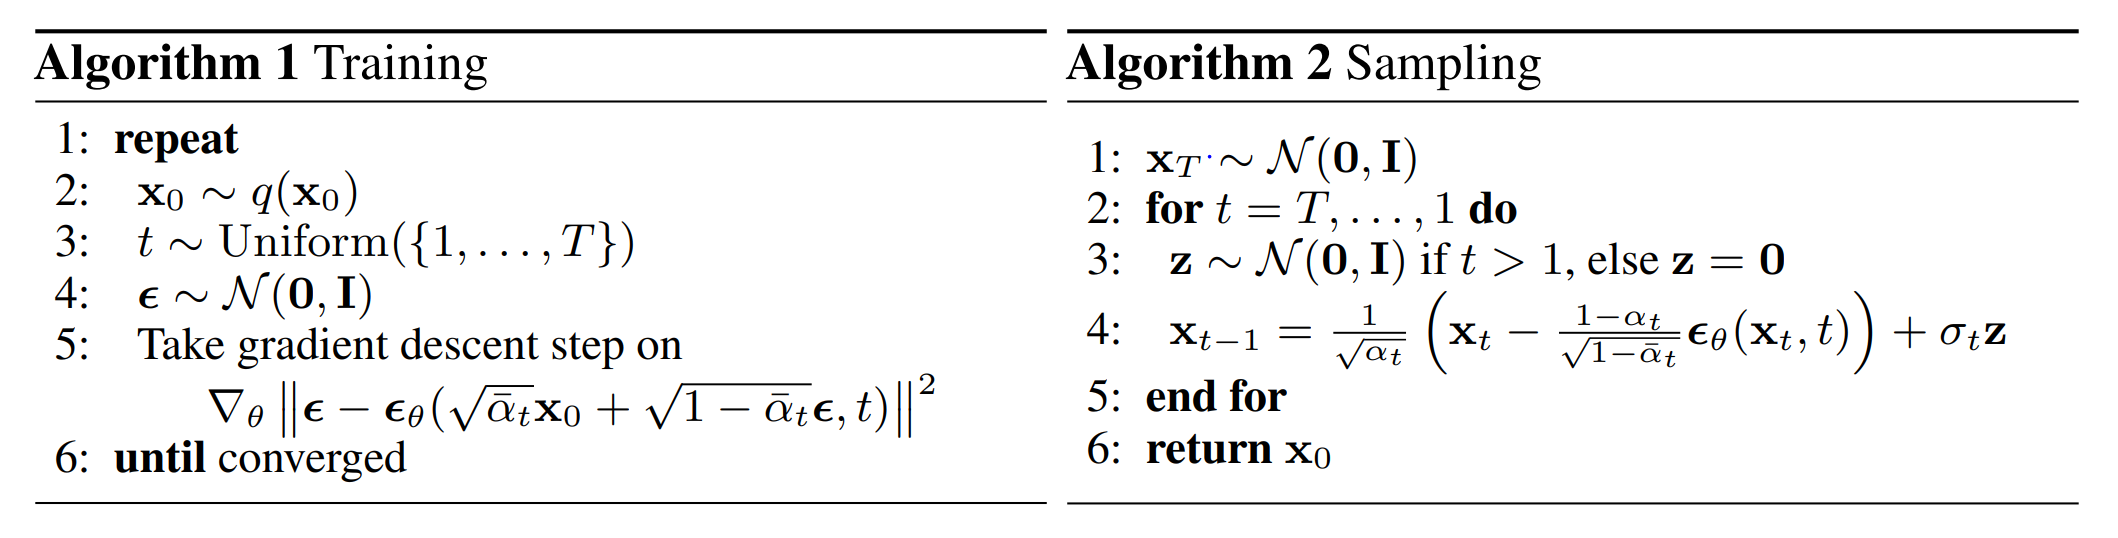

### 1.4.1 Noise scheduling
First of all, we need a variance scheduler for controlling the forward process. For the function in the cell below, define a linear variance scheduler $ \{\beta_t \in (0.0001, 0.04)\}^T_{t=1} $.

In [13]:
def linear_beta_schedule(timesteps):
    """
    Create a linear beta schedule.

    Args:
        timesteps (int): The number of time steps.

    Returns:
        torch.Tensor: A tensor of beta values.
    """
    ##########################################################
    # TODO (1 points):
    # Complete the function with the described instructions.
    ##########################################################
    return torch.linspace(0.0001, 0.04, timesteps, dtype=torch.float32)
    #################### END TODO ############################

### 1.4.2 Foward & Backward Processes

For training and sampling by our diffusion model, you should complete the methods of `Diffusion` class regarding descriptions for each method.

In [14]:
class Diffusion:
    """
    Class for diffusion process.
    Attributes:
    time_steps (int): The number of time steps.
    """
    def __init__(self, time_steps, device):
        self.time_steps = time_steps
        self.device = device

        ##########################################################
        # TODO (3 points):
        # Define beta, alpha, alpha_bar, ...
        # Use linear scheduler
        ##########################################################
        self.betas = linear_beta_schedule(time_steps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0).to(device)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0).to(device)

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod).to(device)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod).to(device)

        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas).to(device)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod).to(device)
        #################### END TODO ############################

    def add_noise(self, x_0, t):
        """
        Add noise to the images.

        Args:
            x_0 (torch.Tensor): the batch of images.
            t (torch.Tensor): 1-D tensor indicating the time step of forward process.

        Returns:
            noisy_images (torch.Tensor): the batch of noisy images for time step t.
            noise (torch.Tensor): the noise added to images (\epsilon in Algorithm 1).
        """
        ##########################################################
        # TODO (4 points):
        # Complete the add_noise with the instructions above.
        ##########################################################
        noise = torch.randn_like(x_0, device=self.device)

        sqrt_alphas_cumprod_t = gather(self.sqrt_alphas_cumprod, t)
        sqrt_one_minus_alphas_cumprod_t = gather(self.sqrt_one_minus_alphas_cumprod, t)

        noised_images = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

        return noised_images, noise
        #################### END TODO ############################

    def train_loss(self, model, x_0, t):
        """
        Computes the MSE loss for training the conditional denoiser model.

        Args:
            model: the denoising U-Net model.
            x_0 (torch.Tensor): the batch of images.
            t (torch.Tensor): 1-D tensor indicating the time step of forward process.
        Returns:
            loss (torch.Tensor): the MSE loss for training the denoising model.
        """
        ##########################################################
        # TODO (2 points):
        # Complete the train_loss with the instructions above.
        ##########################################################
        x_t, true_noise = self.add_noise(x_0, t)

        predicted_noise = model(x_t, t)

        loss = F.mse_loss(true_noise, predicted_noise)

        return loss
        #################### END TODO ############################

    def denoise(self, x_t, pred_noise, t):
        """
        Sample the x_{t-1} from x_t in backward process.

        Args:
            x_t (torch.Tensor): the batch of noisy images for time step t.
            pred_noise (torch.Tensor): the predicted noise by denoising model.
            t (torch.Tensor): 1-D tensor indicating time step values.

        Returns:
            x_{t-1} (torch.Tensor): the sampled noisy images for time step (t-1).
        """
        ##########################################################
        # TODO (6 points):
        # Complete the denoise with the instructions above.
        ##########################################################
        betas_t = gather(self.betas, t)
        sqrt_one_minus_alphas_cumprod_t = gather(self.sqrt_one_minus_alphas_cumprod, t)
        sqrt_recip_alphas_t = gather(self.sqrt_recip_alphas, t)

        model_mean = sqrt_recip_alphas_t * (x_t - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

        if t[0].item() == 0:
            return model_mean
        else:
            posterior_variance_t = gather(self.posterior_variance, t)
            noise = torch.randn_like(x_t, device=self.device)
            return model_mean + torch.sqrt(posterior_variance_t) * noise
        #################### END TODO ############################

    @torch.no_grad()
    def sample(self, n, model, device, image_size=28, channels=1):
        """
        Complete the sampling algorithm and generate images.
        Create a random noise and denoise it from time step T to time step 0 by using self.denoise method.

        Args:
            n (int): Number of generated images.
            model (torch.nn.Module): The UNet network for denoising.
            device (torch.device): Device to perform computations on.
            image_size (int): The spatial size of the image.
            channels (int): The number of image channels.

        Returns:
            generated_images (List): the list of generated grayscale images.
        """
        ##########################################################
        # TODO (6 points):
        # Complete the sample with the instructions above.
        ##########################################################
        model.eval()

        img = torch.randn((n, channels, image_size, image_size), device=device)
        imgs = []

        for t in tqdm(reversed(range(0, self.time_steps)), desc='Sampling', total=self.time_steps):
            t_tensor = torch.full((n,), t, device=device, dtype=torch.long)
            predicted_noise = model(img, t_tensor)

            img = self.denoise(img, predicted_noise, t_tensor)
            imgs.append(img.cpu())

        generated_images = (img.clamp(-1, 1) + 1) / 2

        model.train()
        return [transforms.ToPILImage()(im) for im in generated_images]
        #################### END TODO ############################

In [15]:
# Instantiate an object
time_steps = 100
diffusion = Diffusion(time_steps, device)

## 1.5. Training

At last, in this part we train the model and use it for generating MNIST images.

### 1.5.1 Train the model

Complete the training loop and train the `unet` for using in diffusion process.

In [ ]:
# Instantiate the model
unet = UnetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[2, 4]
)
unet = unet.to(device)

In [ ]:
##########################################################
# TODO (4 points):
# Set the number of epochs and optimizer
# Complete the training loop and train the model.
# Print the average loss of each epoch.
##########################################################
epochs = 20
optimizer = torch.optim.Adam(unet.parameters(), lr=2e-4)

for epoch in range(epochs):
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()

        images, _ = batch
        images = images.to(device)

        t = torch.randint(0, time_steps, (images.shape[0],), device=device).long()

        loss = diffusion.train_loss(unet, images, t)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

#################### END TODO ############################

Epoch 1/20: 100%|██████████| 469/469 [03:34<00:00,  2.19it/s, loss=0.0578]


Epoch 1 completed. Average Loss: 0.0851


Epoch 2/20: 100%|██████████| 469/469 [03:31<00:00,  2.21it/s, loss=0.0494]


Epoch 2 completed. Average Loss: 0.0530


Epoch 3/20: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, loss=0.0488]


Epoch 3 completed. Average Loss: 0.0497


Epoch 4/20: 100%|██████████| 469/469 [03:31<00:00,  2.21it/s, loss=0.047]


Epoch 4 completed. Average Loss: 0.0477


Epoch 5/20: 100%|██████████| 469/469 [03:30<00:00,  2.22it/s, loss=0.0426]


Epoch 5 completed. Average Loss: 0.0469


Epoch 6/20: 100%|██████████| 469/469 [03:31<00:00,  2.21it/s, loss=0.0482]


Epoch 6 completed. Average Loss: 0.0461


Epoch 7/20: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, loss=0.0514]


Epoch 7 completed. Average Loss: 0.0457


Epoch 8/20: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, loss=0.0569]


Epoch 8 completed. Average Loss: 0.0453


Epoch 9/20: 100%|██████████| 469/469 [03:31<00:00,  2.21it/s, loss=0.0431]


Epoch 9 completed. Average Loss: 0.0452


Epoch 10/20: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, loss=0.0416]


Epoch 10 completed. Average Loss: 0.0446


Epoch 11/20: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, loss=0.0408]


Epoch 11 completed. Average Loss: 0.0443


Epoch 12/20: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, loss=0.0431]


Epoch 12 completed. Average Loss: 0.0444


Epoch 13/20: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, loss=0.0432]


Epoch 13 completed. Average Loss: 0.0441


Epoch 14/20: 100%|██████████| 469/469 [03:30<00:00,  2.22it/s, loss=0.0449]


Epoch 14 completed. Average Loss: 0.0440


Epoch 15/20: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, loss=0.0437]


Epoch 15 completed. Average Loss: 0.0436


Epoch 16/20: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, loss=0.0358]


Epoch 16 completed. Average Loss: 0.0436


Epoch 17/20: 100%|██████████| 469/469 [03:30<00:00,  2.22it/s, loss=0.0454]


Epoch 17 completed. Average Loss: 0.0435


Epoch 18/20: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, loss=0.0407]


Epoch 18 completed. Average Loss: 0.0435


Epoch 19/20: 100%|██████████| 469/469 [03:30<00:00,  2.22it/s, loss=0.0449]


Epoch 19 completed. Average Loss: 0.0434


Epoch 20/20: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, loss=0.0418]

Epoch 20 completed. Average Loss: 0.0430


In [ ]:
# Save the trained model
torch.save(unet.state_dict(), '/content/unconditional_unet.pth')

### 1.5.2 Visualize generated images

Sample 100 images from your model and visualize them.

Generating 100 images from the trained model...


Sampling: 100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Generation complete.


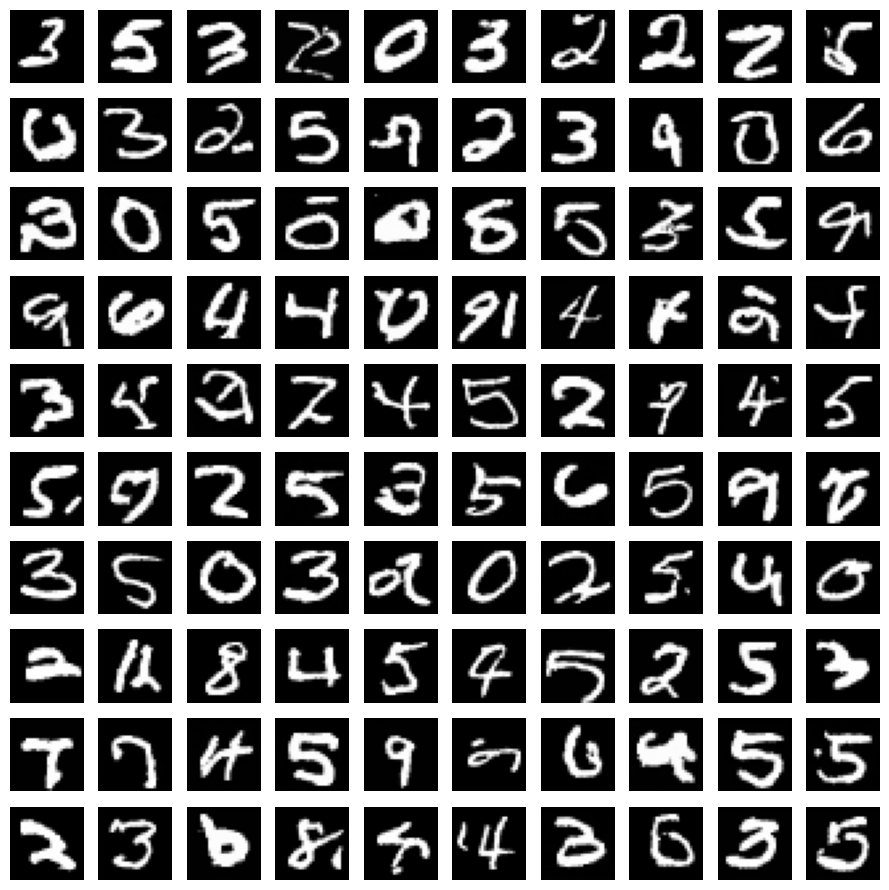

In [ ]:
##########################################################
# TODO (2 points):
# Generate 100 grayscale images and visualize them.
##########################################################
print("Generating 100 images from the trained model...")
generated_images = diffusion.sample(n=100, model=unet, device=device)
print("Generation complete.")

fig, axes = plt.subplots(10, 10, figsize=(9, 9))

axes = axes.ravel()

for i, img in enumerate(generated_images):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')  # Hide the axes

plt.tight_layout()
plt.show()
#################### END TODO ############################

# 2. Conditional DDPM (extra 24 points)

For the second part of the assignment, we aim to develop the conditional diffusion model on the MNIST dataset. The main reference for this part is [classifier-free diffusion guidance paper.](https://arxiv.org/abs/2207.12598). Please note that by using the guidlines of the notebooks, you can complete this part and there is no need to read the paper carefully.

# Introduction

As you know, one way for developing conditional diffusion models is classifier guidance method in which an auxilary classifier is used. Classifier guidance mixes a diffusion model's score estimate with the input gradient of the log probability of a classifier. However, classifier guidance complicates the diffusion model training pipeline because it requires training an extra classifier, and this classifier must be trained on noisy data so it is generally not possible to plug in a pre-trained classifier.

In this part,  we aim to develop a conditional diffusion model without the need to use a classifier. For this purpose, we need to modify the architecture of U-Net model in the previous part to enable it for getting the label of images as inputs.

**Note**: For this part, You can use your codes from the previous part. Actually, by appling slight adjustments to previous codes, you can complete this part.

## 2.1 Conditional U-Net Architecture

As the new inputs for the conditional U-Net model, we need **two new inputs**:

* Input for class labels

* 0-1 Masks for determining unconditional / conditional model. (if 0, model doesn't use class labels for predicting noise, if 1, model use class labels for predicting noise.

The second input will be useful for training and sampling algorithms.

**Hint**: For modules of U-Net not mentioned here, you can use the implementations from the previous part.

### 2.1.1 time step and class embedding class
We define the `TimestepClassEmbedSequential` to support the time embedding as the extra input for the layers of model.

In [16]:
class TimestepBlock(nn.Module):
    @abstractmethod
    def foward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepClassEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, t_emb, c_emb, mask):
        for layer in self:
            if(isinstance(layer, TimestepBlock)):
                x = layer(x, t_emb, c_emb, mask)
            else:
                x = layer(x)
        return x


### 2.1.2 Conditional Residual Block


First, we need to change the implementation of residual block. This modules gets **class labels embeddings** and **condition flag masks** as inputs. For implementation, you can use a *feed-forward layer for label embeddings, and apply the mask on the output of this layer*. Then, you can add the output to the time embedding and image embedding at the **residual connection**.

In [17]:
# Residual block
class Conditional_Residual_block(TimestepBlock):
    """
    Conditional Residual block for Conditional U-Net architecture.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        time_channels (int): Size of the time embedding.
        class_channels (int): Size of the class embedding.
        dropout (float, optional): Dropout probability.
        num_groups (int): Number of groups to split the input into for normalization. Default is 32.
    """
    ##########################################################
    # TODO (6 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self, in_channels, out_channels, time_channels, class_channels, dropout, num_groups=32):
        super().__init__()
        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.act2 = nn.SiLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.time_emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.class_emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(class_channels, out_channels)
        )

        if in_channels == out_channels:
            self.residual_connection = nn.Identity()
        else:
            self.residual_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x, t, c, mask):
        """
        Forward pass of the ResnetBlock.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.
            c (torch.Tensor): Class embedding tensor.
            mask (torch.Tensor): Conditional mask tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        h = self.conv1(self.act1(self.norm1(x)))

        time_emb = self.time_emb_proj(t)
        class_emb = self.class_emb_proj(c)

        class_emb = class_emb * mask.unsqueeze(-1)

        combined_emb = time_emb + class_emb
        h = h + combined_emb.unsqueeze(-1).unsqueeze(-1)
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))

        return h + self.residual_connection(x)

    #################### END TODO ############################

### 2.1.3 Final Architecture

In this step, we implement the conditional U-Net model. You can use the same architecture used for the unconditional generation. However, you should use the contional residual connection to enable the model for the conditional generation.

Notes:
* Same as the time embedding, you need to transform the class labels to embedding vectors. For this purpose, you can use `nn.Embedding` module.

In [18]:
class ConditionalUnetModel(nn.Module):
    """
    U-Net model for image generation.

    Args:
        in_channels (int): Number of input channels.
        model_channels (int): Number of channels in the model.
        out_channels (int): Number of output channels.
        num_res_blocks (int): Number of residual blocks at each level in the model.
        attention_resolutions (list): List of resolutions at which to apply attention.
        dropout (float): Dropout probability.
        channel_mult (list): List of channel multipliers for each stage (should be multiplied to model_channels).
        conv_resample (bool): Flag indicating whether to use convolution for up/down sampling blocks.
        num_heads (int): Number of attention heads.
        class_num (int): Number of classes.
        num_groups (int): Number of groups to split the input into for normalization.
    """
    ##########################################################
    # TODO (6 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self,
                 in_channels=3,
                 model_channels=128,
                 out_channels=3,
                 num_res_blocks=2,
                 attention_resolutions=(8,16),
                 dropout=0,
                 channel_mult=(1,2,2,2),
                 conv_resample=True,
                 num_heads=4,
                 class_num=10,
                 num_groups=32
                ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        self.class_num = class_num
        self.num_groups = num_groups

        #time embedding
        time_emb_dim = model_channels * 4
        self.time_mlp = nn.Sequential(
            nn.Linear(model_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        #class embedding
        class_emb_dim = model_channels
        self.class_embedding = nn.Embedding(class_num, class_emb_dim)

        self.conv_in = nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)

        #down blocks
        self.down_blocks = nn.ModuleList()
        skip_channels = [model_channels]
        ch = model_channels
        current_res = 28

        for i, mult in enumerate(channel_mult):
            out_ch = model_channels * mult
            for _ in range(num_res_blocks):
                self.down_blocks.append(
                    Conditional_Residual_block(ch, out_ch, time_emb_dim, class_emb_dim, dropout, num_groups)
                )
                ch = out_ch
                if current_res in attention_resolutions:
                    self.down_blocks.append(AttentionBlock(ch, num_groups, num_heads))
                skip_channels.append(ch)

            if i != len(channel_mult) - 1:
                self.down_blocks.append(Downsample(ch, conv_resample))
                current_res //= 2
                skip_channels.append(ch)

        #middle blocks
        self.middle_block = nn.ModuleList([
            Conditional_Residual_block(ch, ch, time_emb_dim, class_emb_dim, dropout, num_groups),
            AttentionBlock(ch, num_groups, num_heads),
            Conditional_Residual_block(ch, ch, time_emb_dim, class_emb_dim, dropout, num_groups),
        ])

        #up blocks
        self.up_blocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(channel_mult))):
            out_ch = model_channels * mult
            for _ in range(num_res_blocks + 1):
                in_ch = ch + skip_channels.pop()
                self.up_blocks.append(
                    Conditional_Residual_block(in_ch, out_ch, time_emb_dim, class_emb_dim, dropout, num_groups)
                )
                ch = out_ch
                if current_res in attention_resolutions:
                    self.up_blocks.append(AttentionBlock(ch, num_groups, num_heads))

            if i != 0:
                self.up_blocks.append(Upsample(ch, conv_resample))
                current_res *= 2

        self.out = nn.Sequential(
            nn.GroupNorm(num_groups, ch),
            nn.SiLU(),
            nn.Conv2d(ch, self.out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps, c, mask):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param c: a 1-D batch of classes.
        :param mask: a 1-D batch of conditioned/unconditioned.
        :return: an [N x C x ...] Tensor of outputs.
        """
        t_emb = self.time_mlp(timestep_embedding(timesteps, self.model_channels))
        c_emb = self.class_embedding(c)

        h = self.conv_in(x)
        hs = [h]

        for block in self.down_blocks:
            if isinstance(block, Conditional_Residual_block):
                 h = block(h, t_emb, c_emb, mask)
            elif isinstance(block, AttentionBlock):
                 h = block(h)
            else:
                 h = block(h)
            hs.append(h)

        for block in self.middle_block:
            if isinstance(block, Conditional_Residual_block):
                h = block(h, t_emb, c_emb, mask)
            else:
                h = block(h)

        for block in self.up_blocks:
            if isinstance(block, Conditional_Residual_block):
                skip_h = hs.pop()
                h = torch.cat([h, skip_h], dim=1)
                h = block(h, t_emb, c_emb, mask)
            elif isinstance(block, AttentionBlock):
                h = block(h)
            else:
                h = block(h)

        return self.out(h)


    #################### END TODO ############################

## 2.2 Classifier-free guidance diffusion process

As it is stated in the reference paper, for training the model, we need to train it for both unconditional and conditional inputs. Therefore, we need to consider both inputs through training. The training algorithm is:

Training algorithm:

Require $p_{uncond}$: Probability of unconditional training

1. **repeat**
2. $ (x, c) \sim q(x, c)$
3. mask = 0 with the probability $p_{uncond}$
3. $t \sim Uniform(\{1, 2, ..., T\})$
4. $\epsilon \sim N(0, I)$
5. Take gradient descent on

&emsp;&emsp; $\nabla_{\theta} ||\epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon, t, c, mask)||$
6. **until** converged

For sampling, as the similar as the classifier guidance method, we need to use the predcited noise of conditional model to generate the image for a certain class. The sampling algorithm is:

Sampling algorithm

define $w$: guidance strength
1. $ x_T \sim N(0, I) $
2. for $ t = T, \ldots, 1 $ do
3. &emsp;&emsp;$ z \sim N(0, I) $ if $ t > 1 $, else $ z = 0 $
4. &emsp;&emsp;$\epsilon_{pred} = (1+w)\epsilon_{\theta}(x_t, t, c, I) - w\epsilon_{\theta}(x_t, t, c, 0)$
5. &emsp;&emsp;$ x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_{pred} \right) + \sigma_t z $
5. end for
6. return $ x_0 $

In [19]:
class ConditionalDiffusion:
  """
  Class for conditional diffusion process.
  Attributes:
    time_steps (int): The number of time steps.
    w (int): Guidance strength parameter. default is 2.
    p_uncond (float): Probability of unconditional training. default is 0.2.
  """
  def __init__(self, time_steps, w=2, p_uncond=0.2):
    self.time_steps = time_steps
    self.w = w
    self.p_uncond = p_uncond

    self.betas = linear_beta_schedule(time_steps).to(device)
    self.alphas = 1. - self.betas
    self.alphas_cumprod = torch.cumprod(self.alphas, axis=0).to(device)
    self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0).to(device)

    self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod).to(device)
    self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod).to(device)

    self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas).to(device)
    self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod).to(device)

  def add_noise(self, x_0, t):
    """
    Add noise to the images.

    Args:
      x_0 (torch.Tensor): the batch of images.
      t (torch.Tensor): 1-D tensor indicating the time step of forward process.

    Returns:
      noisy_images (torch.Tensor): the batch of noisy images for time step t.
      noise (torch.Tensor): the noise added to images (\epsilon in Algorithm 1).
    """
    ##########################################################
    # TODO:
    # Complete the add_noise with the instructions above.
    ##########################################################
    noise = torch.randn_like(x_0)

    sqrt_alphas_cumprod_t = gather(self.sqrt_alphas_cumprod, t)
    sqrt_one_minus_alphas_cumprod_t = gather(self.sqrt_one_minus_alphas_cumprod, t)

    noised_images = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
    return noised_images, noise
    #################### END TODO ############################

  def train_loss(self, model, x_0, t, label):
    """
    Computes the MSE loss for training the conditional denoiser model.

    Args:
      model: the denoising U-Net model.
      x_0 (torch.Tensor): the batch of images.
      t (torch.Tensor): 1-D tensor indicating the time step of forward process.
      label (torch.Tensor): 1-D tensor indicating labels.
    Returns:
      loss (torch.Tensor): the MSE loss for training the denoising model.
    """
    ##########################################################
    # TODO:
    # Complete the train_loss with the instructions above.
    ##########################################################
    prob_mask = torch.rand(x_0.shape[0], device=x_0.device)
    mask = (prob_mask > self.p_uncond).float()

    x_t, true_noise = self.add_noise(x_0, t)

    predicted_noise = model(x_t, t, label, mask)

    loss = F.mse_loss(true_noise, predicted_noise)

    return loss
    #################### END TODO ############################

  def denoise(self, x_t, pred_noise, t):
    """
    Sample the x_{t-1} from x_t in backward process.

    Args:
      x_t (torch.Tensor): the batch of noisy images for time step t.
      pred_noise (torch.Tensor): the predicted noise (\epsilon_{pred} in sampling algorithm)
      t (torch.Tensor): 1-D tensor indicating time step values.

    Returns:
      x_{t-1} (torch.Tensor): the sampled noisy images for time step (t-1).
    """
    ##########################################################
    # TODO:
    # Complete the denoise with the instructions above.
    ##########################################################
    betas_t = gather(self.betas, t)
    sqrt_one_minus_alphas_cumprod_t = gather(self.sqrt_one_minus_alphas_cumprod, t)
    sqrt_recip_alphas_t = gather(self.sqrt_recip_alphas, t)

    model_mean = sqrt_recip_alphas_t * (x_t - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t[0].item() == 0:
      return model_mean
    else:
      posterior_variance_t = gather(self.posterior_variance, t)
      noise = torch.randn_like(x_t)
      return model_mean + torch.sqrt(posterior_variance_t) * noise

    #################### END TODO ############################
  @torch.no_grad()
  def sample(self, n, model, label, device, image_size=28, channels=1):
    """
    Complete the sampling algorithm and generate images.
    create a random noise and denoise it from time step T to time step 0 by using self.denoise method.

    Args:
      n (int): Number of generated images.
      model (torch.nn.Module): The UNet network for denoising.
      label (torch.Tensor): 1-D tensor indicating labels.
      device (torch.device): Device to perform computations on.

    Returns:
      generated_images (List): the list of generated grayscale images.
    """
    ##########################################################
    # TODO (4 points):
    # Complete the sample with the instructions above.
    ##########################################################
    model.eval()

    img = torch.randn((n, channels, image_size, image_size), device=device)

    mask_cond = torch.ones_like(label).float().to(device)
    mask_uncond = torch.zeros_like(label).float().to(device)

    for t in tqdm(reversed(range(0, self.time_steps)), desc="Sampling", total=self.time_steps):
      t_tensor = torch.full((n,), t, device=device, dtype=torch.long)

      cond_noise = model(img, t_tensor, label, mask_cond)
      uncond_noise = model(img, t_tensor, label, mask_uncond)

      pred_noise = (1 + self.w) * cond_noise - self.w * uncond_noise

      img = self.denoise(img, pred_noise, t_tensor)

    generated_images = (img.clamp(-1, 1) + 1) / 2

    model.train()
    return [transforms.ToPILImage()(im) for im in generated_images]
    #################### END TODO ############################

In [20]:
# Get an instance
time_steps = 100
conditional_diffusion = ConditionalDiffusion(time_steps=time_steps, w=2, p_uncond=0.2)

## 2.3 Training

### 2.3.1 Train the model

Complete the training loop and train the `conditional_unet` for using in diffusion process.

In [ ]:
conditional_unet = ConditionalUnetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[2, 4],
    class_num=10
)
conditional_unet = conditional_unet.to(device)

In [ ]:
##########################################################
# TODO (6 points):
# Set the number of epochs and optimizer
# Complete the training loop and train the model.
# Print the average loss of each epoch.
##########################################################
epochs = 25
optimizer = torch.optim.Adam(conditional_unet.parameters(), lr=2e-4)

for epoch in range(epochs):
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()

        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        t = torch.randint(0, time_steps, (images.shape[0],), device=device).long()

        loss = conditional_diffusion.train_loss(conditional_unet, images, t, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")
#################### END TODO ############################

Epoch 1/25: 100%|██████████| 469/469 [03:21<00:00,  2.33it/s, loss=0.0594]


Epoch 1 completed. Average Loss: 0.0896


Epoch 2/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0496]


Epoch 2 completed. Average Loss: 0.0532


Epoch 3/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0469]


Epoch 3 completed. Average Loss: 0.0495


Epoch 4/25: 100%|██████████| 469/469 [03:26<00:00,  2.28it/s, loss=0.0539]


Epoch 4 completed. Average Loss: 0.0478


Epoch 5/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0453]


Epoch 5 completed. Average Loss: 0.0466


Epoch 6/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0509]


Epoch 6 completed. Average Loss: 0.0460


Epoch 7/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0408]


Epoch 7 completed. Average Loss: 0.0453


Epoch 8/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0426]


Epoch 8 completed. Average Loss: 0.0449


Epoch 9/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0451]


Epoch 9 completed. Average Loss: 0.0444


Epoch 10/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0411]


Epoch 10 completed. Average Loss: 0.0446


Epoch 11/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.039]


Epoch 11 completed. Average Loss: 0.0441


Epoch 12/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0398]


Epoch 12 completed. Average Loss: 0.0439


Epoch 13/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0448]


Epoch 13 completed. Average Loss: 0.0437


Epoch 14/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0378]


Epoch 14 completed. Average Loss: 0.0435


Epoch 15/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0387]


Epoch 15 completed. Average Loss: 0.0435


Epoch 16/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0411]


Epoch 16 completed. Average Loss: 0.0434


Epoch 17/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0532]


Epoch 17 completed. Average Loss: 0.0432


Epoch 18/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0452]


Epoch 18 completed. Average Loss: 0.0432


Epoch 19/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0435]


Epoch 19 completed. Average Loss: 0.0428


Epoch 20/25: 100%|██████████| 469/469 [03:26<00:00,  2.28it/s, loss=0.0429]


Epoch 20 completed. Average Loss: 0.0429


Epoch 21/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0433]


Epoch 21 completed. Average Loss: 0.0426


Epoch 22/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0369]


Epoch 22 completed. Average Loss: 0.0425


Epoch 23/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0392]


Epoch 23 completed. Average Loss: 0.0427


Epoch 24/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0426]


Epoch 24 completed. Average Loss: 0.0425


Epoch 25/25: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s, loss=0.0379]

Epoch 25 completed. Average Loss: 0.0425


In [ ]:
# Save the trained model
torch.save(conditional_unet.state_dict(), '/content/conditional_unet.pth')

### 2.3.2 Visualize generated images

For the visualization part, you should generate images of 0-9 classes 10 times and visualiza them like the output of below cell.

Sampling: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


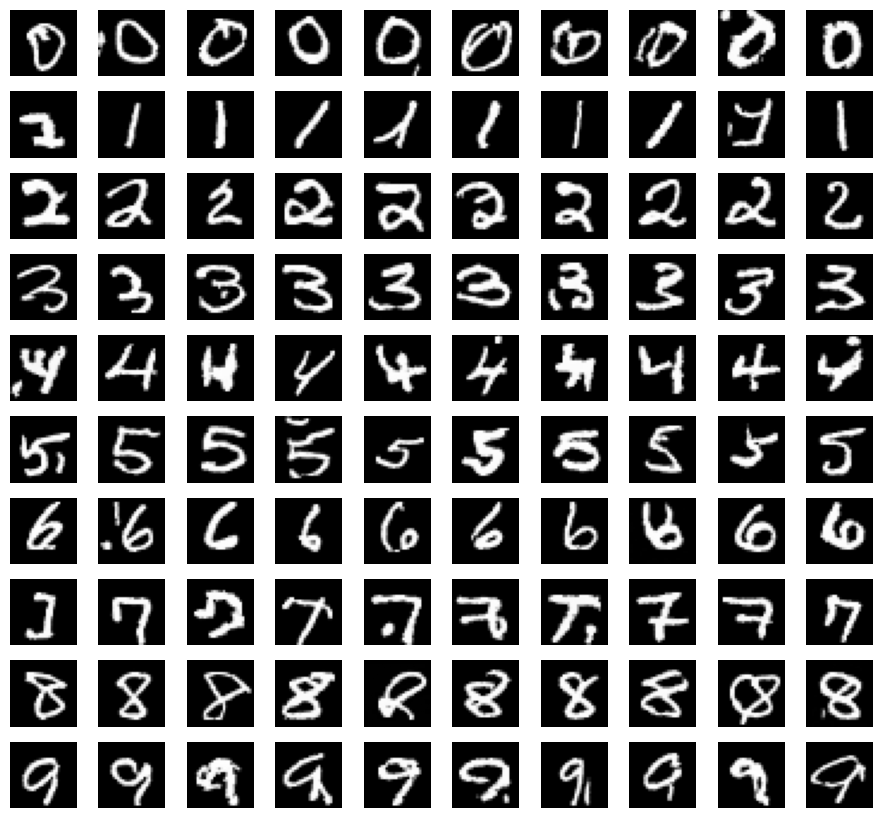

In [ ]:
##########################################################
# TODO (2 points):
# Generate 100 grayscale 0-9 images and visualize them.
##########################################################
conditional_unet.eval()

n_classes = 10
n_samples_per_class = 10
total_images = n_classes * n_samples_per_class

labels = torch.arange(n_classes, device=device).repeat_interleave(n_samples_per_class)

generated_images = conditional_diffusion.sample(
    n=total_images,
    model=conditional_unet,
    label=labels,
    device=device
)

fig, axes = plt.subplots(n_classes, n_samples_per_class, figsize=(9, 9))

for i, img in enumerate(generated_images):

    row = i // n_samples_per_class
    col = i % n_samples_per_class


    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].axis('off')


    if col == 0:
        axes[row, col].set_ylabel(f"Digit: {row}", fontsize=12, labelpad=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#################### END TODO ############################

# 3. Evaluation (extra 10 points)

For this part, you should measure the quality of generated images by (unconditional or conditional model) in comparison to the real images. You are free to choose any appropriate metric for this purpose. Also, you are free to implement this part from scratch or use an additional library. In the cell below, write a brief description about your chosen metric and how it works.

`Your answer`:\
For evaluating the generated images, a suitable metric is the Fréchet MNIST Distance (FMD), which is a domain-specific version of the well-known Fréchet Inception Distance (FID).

It's chosen over the standard FID to avoid the "domain mismatch" that occurs when using a model pre-trained on real-world color photos (ImageNet) to evaluate simple grayscale digits (MNIST).

### How Fréchet MNIST Distance (FMD) Works

FMD measures the similarity between the distribution of generated images and the distribution of real MNIST images in a feature space. A lower score indicates the distributions are more similar, implying higher quality and more diverse generated images.

The process is as follows:

1.  **Train a Reference Classifier**: A simple Convolutional Neural Network (CNN) is first trained on the real MNIST dataset. This model learns to extract features that are meaningful for distinguishing handwritten digits.

2.  **Extract Features**: This trained classifier is then used as a feature extractor. Both a large set of real MNIST images and a large set of generated images are passed through the network, and the activations from an intermediate layer (e.g., the last fully-connected layer before the output) are collected.

3.  **Calculate Distribution Statistics**: The two sets of feature vectors are each modeled as a multivariate Gaussian distribution. The mean vector and covariance matrix are calculated for both the real and generated feature sets.

4.  **Compute Distance**: The Fréchet distance between these two Gaussian distributions is calculated. This distance considers the differences in both the means and the covariance matrices, thus capturing changes in both the mode and diversity of the generated samples.

In [24]:
##########################################################
# TODO (10 points):
# Evaluate the quality of generated images by choosing and using an appropriate metric.
##########################################################
import scipy.linalg
from torch.utils.data import TensorDataset, DataLoader

class MnistClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        features = self.fc1(x)
        x = self.dropout2(F.relu(features))
        output = self.fc2(x)
        return output, features

print("Training a simple MNIST classifier for evaluation...")
classifier = MnistClassifier().to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
classifier.train()
for epoch in range(5):
    for images, labels in tqdm(dataloader, desc=f"Training Classifier Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def calculate_fmd(features1, features2):
    """Calculates the Frechet distance between two sets of feature vectors."""
    mu1, sigma1 = features1.mean(axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = features2.mean(axis=0), np.cov(features2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)[0]

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fmd = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fmd

@torch.no_grad()
def get_features(images, model, device):
    feature_list = []

    dataset = TensorDataset(images)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    for batch in tqdm(loader, desc="Extracting features"):
        img_batch = batch[0].to(device)
        _, features = model(img_batch)
        feature_list.append(features.cpu().numpy())
    return np.concatenate(feature_list, axis=0)


N_SAMPLES = 500
gen_batch_size = 128
batch_size = 128

print(f"\nGetting features from {N_SAMPLES} real MNIST images...")
real_images = torch.cat([batch[0] for i, batch in enumerate(dataloader) if i * batch_size < N_SAMPLES])[:N_SAMPLES]
classifier.eval()
real_features = get_features(real_images, classifier, device)

print(f"Generating {N_SAMPLES} fake images in batches of {gen_batch_size}...")
fake_images_pil = []
n_classes = 10
labels_full = torch.arange(n_classes).repeat_interleave(N_SAMPLES // n_classes).to(device)
conditional_unet.eval()

for i in tqdm(range(0, N_SAMPLES, gen_batch_size), desc="Generating Fake Images"):
    batch_labels = labels_full[i : i + gen_batch_size]
    if batch_labels.shape[0] == 0:
        continue

    with torch.no_grad():
        generated_batch = conditional_diffusion.sample(
            n=batch_labels.shape[0],
            model=conditional_unet,
            label=batch_labels,
            device=device
        )
    fake_images_pil.extend(generated_batch)

fake_images_tensor = torch.stack([transforms.ToTensor()(img) for img in fake_images_pil])
fake_images_tensor = (fake_images_tensor * 2) - 1
fake_features = get_features(fake_images_tensor, classifier, device)

print("\nCalculating Fréchet MNIST Distance (FMD)...")
fmd_score = calculate_fmd(real_features, fake_features)

print("\n" + "="*30)
print(f"Evaluation Result:")
print(f"Fréchet MNIST Distance (FMD): {fmd_score:.4f}")
print("A lower FMD score indicates better image quality and diversity.")
print("="*30)

#################### END TODO ############################

Training a simple MNIST classifier for evaluation...


Training Classifier Epoch 5: 100%|██████████| 469/469 [00:12<00:00, 36.46it/s]



Getting features from 500 real MNIST images...


Extracting features: 100%|██████████| 8/8 [00:00<00:00, 512.03it/s]


Generating 500 fake images in batches of 128...


Extracting features: 100%|██████████| 8/8 [00:00<00:00, 779.03it/s]


Calculating Fréchet MNIST Distance (FMD)...

Evaluation Result:
Fréchet MNIST Distance (FMD): 278.3345
A lower FMD score indicates better image quality and diversity.
